# Make ERA5 shapefile
The shapefile for the forcing data needs to represent the regular latitude/longitude grid of the ERA5 data. We need this for later intersection with the catchment shape(s) so we can create appropriately weighted forcing for each model element. 

Note that ERA5 data should be thought of as being provided for a specific point in space. These points are the lat/lon coordinates found as netcdf dimensions in the data files. Here, these coordinates will act as center points for a grid. Each point is assumed to be representative for an equal-sized area around itself. See: https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference

We'll also add the elevation of each ERA5 grid cell for later temperature lapse rates. As per ERA5 docs, geopotential `[m^2 s^-2]` can be divided by `g=9.80665` `[m s^-2]` to obtain ERA5 elevation in `[m]`. Source: https://confluence.ecmwf.int/display/CKB/ERA5%3A+surface+elevation+and+orography#ERA5:surfaceelevationandorography-Howtocalculatesurfacegeopotentialheight

#### Acknowledgements
The code to generate the shapefile is inspired by a function from the EASYMORE toolbox: https://github.com/ShervanGharari/EASYMORE/. 

In [1]:
# modules
import os
import shapefile # this is installed as "PyShp" library
import numpy as np
import xarray as xr
import netCDF4 as nc4
import geopandas as gpd
from pathlib import Path
from shutil import copyfile
from datetime import datetime
import matplotlib.pyplot as plt

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find location of merged forcing data

In [6]:
# Find the path where the merged forcing is
mergePath = read_from_control(controlFolder/controlFile,'forcing_merged_path')

In [7]:
# Specify the default path if required
if mergePath == 'default':
    mergePath = make_default_path('forcing/2_merged_data')
else: 
    mergePath = Path(mergePath) # ensure Path() object 

#### Find spatial extent of domain

In [8]:
# Find which locations to download
coordinates = read_from_control(controlFolder/controlFile,'forcing_raw_space')

#### Find location of geopotential data file

In [9]:
# Find file path
geoPath = read_from_control(controlFolder/controlFile,'forcing_geo_path')

In [10]:
# Specify the default path if required
if geoPath == 'default':
    geoPath = make_default_path('forcing/0_geopotential')
else: 
    geoPath = Path(geoPath) # ensure Path() object 

In [11]:
# Specify the filename
geoName = 'ERA5_geopotential.nc'

#### Find where the shapefile needs to go

In [12]:
# Find the path where the new shapefile needs to go
shapePath = read_from_control(controlFolder/controlFile,'forcing_shape_path')

In [13]:
# Specify the default path if required
if shapePath == 'default':
    shapePath = make_default_path('shapefiles/forcing')
else: 
    shapePath = Path(shapePath) # ensure Path() object 

In [14]:
# Find name of the new shapefil
shapeName = read_from_control(controlFolder/controlFile,'forcing_shape_name')

In [15]:
# Find the names of the latitude and longitude fields
field_lat = read_from_control(controlFolder/controlFile,'forcing_shape_lat_name')
field_lon = read_from_control(controlFolder/controlFile,'forcing_shape_lon_name')

#### Read the source file to find the grid spacing

In [16]:
# Find an .nc file in the forcing path
for file in os.listdir(mergePath):
    if file.endswith('.nc'):
        forcing_file = file
        break

In [17]:
# Set the dimension variable names
source_name_lat = "latitude"
source_name_lon = "longitude"

In [18]:
# Open the file and get the dimensions
with nc4.Dataset(mergePath / forcing_file) as src:
    lat = src.variables[source_name_lat][:]
    lon = src.variables[source_name_lon][:]

In [19]:
# Find the spacing
half_dlat = abs(lat[1] - lat[0])/2
half_dlon = abs(lon[1] - lon[0])/2

#### Create the new shape

In [20]:
# create a new shapefile object
with shapefile.Writer(str(shapePath / shapeName)) as w:
    w.autoBalance = 1 # turn on function that keeps file stable if number of shapes and records don't line up
    w.field("ID",'N') # create (N)umerical attribute fields, integer
    w.field(field_lat,'F',decimal=4) # float with 4 decimals
    w.field(field_lon,'F',decimal=4)
    ID = 0 # start ID counter of empty
    
    for i in range(0,len(lon)):
        for j in range(0,len(lat)):
            ID += 1
            center_lon = lon[i]
            center_lat = lat[j]
            vertices = []
            parts = []
            vertices.append([center_lon-half_dlon, center_lat])
            vertices.append([center_lon-half_dlon, center_lat+half_dlat])
            vertices.append([center_lon          , center_lat+half_dlat])
            vertices.append([center_lon+half_dlon, center_lat+half_dlat])
            vertices.append([center_lon+half_dlon, center_lat])
            vertices.append([center_lon+half_dlon, center_lat-half_dlat])
            vertices.append([center_lon          , center_lat-half_dlat])
            vertices.append([center_lon-half_dlon, center_lat-half_dlat])
            vertices.append([center_lon-half_dlon, center_lat])
            parts.append(vertices)
            w.poly(parts)
            w.record(ID, center_lat, center_lon)

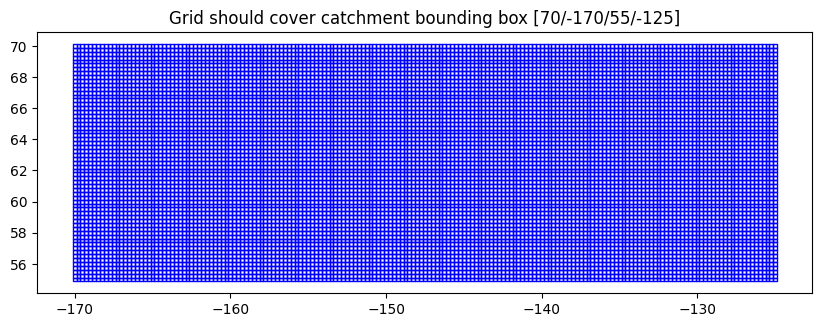

In [21]:
# plot the shapefile to see if this matches the bounds
shp = gpd.read_file( shapePath / shapeName )
shp.plot(figsize=(10,10), facecolor='none', edgecolor='b');
plt.title('Grid should cover catchment bounding box [{}]'.format(coordinates));

#### Add the geopotential data to the shape

In [22]:
# Open the geopotential data file
geo = xr.open_dataset( geoPath / geoName ).isel(time=0)

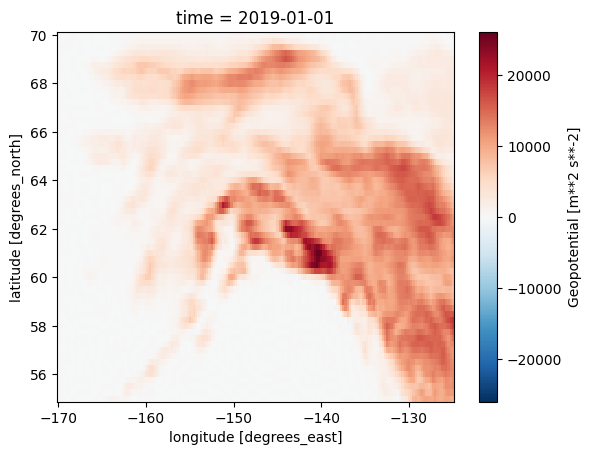

In [23]:
# plot the geopotential data to check
geo['z'].plot();

In [24]:
# Open shapefile (again)
shp = gpd.read_file( shapePath / shapeName )

In [25]:
# Define the constant
g = 9.80665

In [26]:
# Add new column to shapefile
shp = shp.assign(elev_m = -999)  # insert a placeholder value

In [27]:
# For each row in the shapefile, match its ERA5 lat/lon coordinates 
# with those in the 'geo' file and extract the appropriate geopotential
for index, row in shp.iterrows():
       
    # Find elevation
    elev = geo['z'].sel(latitude = row['lat'], longitude=row['lon']).values.flatten() / g
    
    # Add elevation into shapefile
    shp.at[index,'elev_m'] = elev[0]

/var/folders/pc/q8630ffx72z0bwfzz59ws0kc0000gn/T/ipykernel_48643/42251351.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01754879578948021' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  shp.at[index,'elev_m'] = elev[0]


In [28]:
# Check
shp

,ID,lat,lon,geometry,elev_m
0,1.0,70.00,-170.0,"POLYGON ((-170.12500 70.00000, -170.12500 70.1...",0.017549
1,2.0,69.75,-170.0,"POLYGON ((-170.12500 69.75000, -170.12500 69.8...",-0.569485
2,3.0,69.50,-170.0,"POLYGON ((-170.12500 69.50000, -170.12500 69.6...",-0.317942
3,4.0,69.25,-170.0,"POLYGON ((-170.12500 69.25000, -170.12500 69.3...",0.394864
4,5.0,69.00,-170.0,"POLYGON ((-170.12500 69.00000, -170.12500 69.1...",0.352940
...,...,...,...,...,...
11036,11037.0,56.00,-125.0,"POLYGON ((-125.12500 56.00000, -125.12500 56.1...",1281.026978
11037,11038.0,55.75,-125.0,"POLYGON ((-125.12500 55.75000, -125.12500 55.8...",1228.867432
11038,11039.0,55.50,-125.0,"POLYGON ((-125.12500 55.50000, -125.12500 55.6...",1253.856934
11039,11040.0,55.25,-125.0,"POLYGON ((-125.12500 55.25000, -125.12500 55.3...",1130.376587


In [29]:
# Overwrite the existing shapefile
shp.to_file( shapePath / shapeName )

In [30]:
# close the files
geo.close()
shp = []

#### Code provenance
Generates a basic log file in the domain folder and copies the control file and itself there.

In [31]:
# Create a log folder
logFolder = '_workflow_log'
Path( shapePath / logFolder ).mkdir(parents=True, exist_ok=True)

In [32]:
# Copy this script
thisFile = 'create_ERA5_shapefile.ipynb'
copyfile(thisFile, shapePath / logFolder / thisFile);

In [33]:
# Get current date and time
now = datetime.now()

In [34]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + '_forcing_shapefile_log.txt'
with open( shapePath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Created ERA5 regular latitude/longitude grid.']
    for txt in lines:
        file.write(txt) 